In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
# Thư viện chứa model Gaussian Mixture

In [42]:
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv", header=0, index_col=0)
print(data.shape)
data.head()

# Lấy ra các cột Normalized
X = data.iloc[:, 55:].values

# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(811, 106)
(811, 51)


In [43]:
#PCA
pca = PCA(n_components=2)
X_std = pca.fit_transform(X_std)
X_std.shape

(811, 2)

In [44]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[ 1.20323089  0.13627159]
 [-1.31959555 -0.34116262]
 [ 0.09480898  0.35151043]
 [ 1.6857803  -0.35336216]
 [-0.70520602  0.14716503]]
covariances: 
  [[[ 0.13113125 -0.00804403]
  [-0.00804403  0.11328773]]

 [[ 0.11248306  0.00262973]
  [ 0.00262973  0.08648281]]

 [[ 0.1284991   0.00162717]
  [ 0.00162717  0.11519752]]

 [[ 0.05268064 -0.00958845]
  [-0.00958845  0.05990212]]

 [[ 0.08508599 -0.02481794]
  [-0.02481794  0.14302063]]]


Số cụm tối ưu sẽ nằm trong khoảng từ 5 đến 15, tìm số cụm tốt nhất

5
5
6


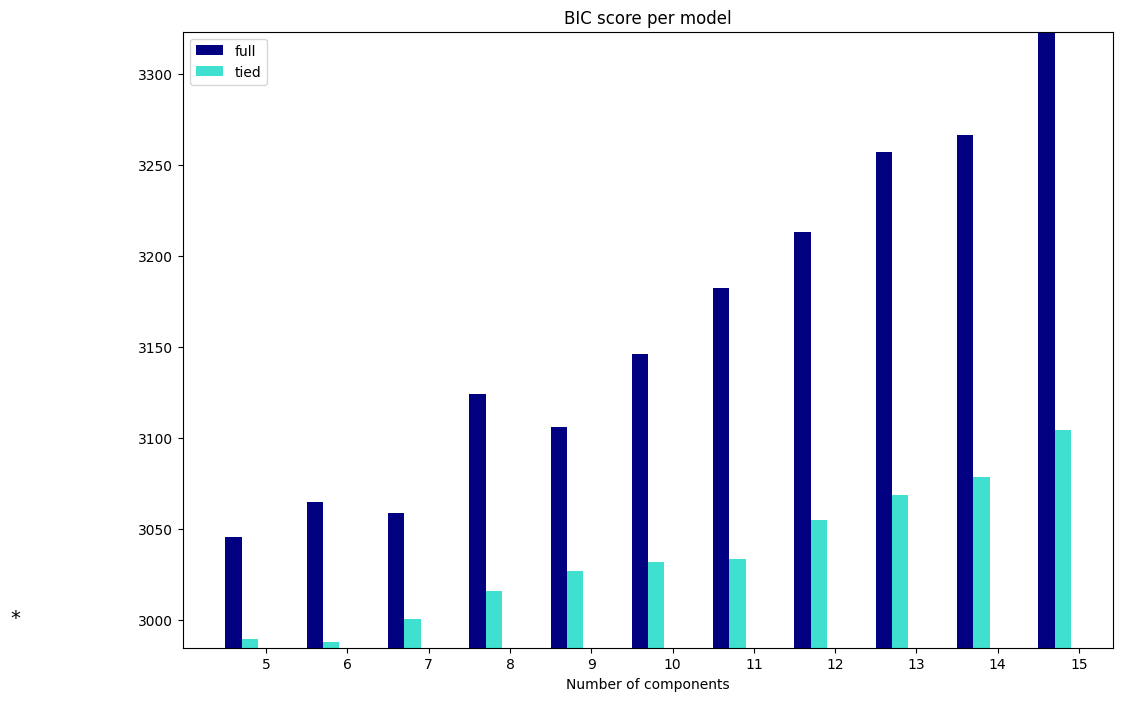

In [45]:
lowest_bic = np.infty
bic = []

# từ 5 - 15
n_components_range = range(5, 16)

# cv_types = ['spherical', 'tied', 'diag', 'full']
cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:

        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            print(n_components)

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))

plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

* Vậy số cụm là 6 cho kết quả tốt nhất

Vẽ kết quả với dữ liệu đã PCA

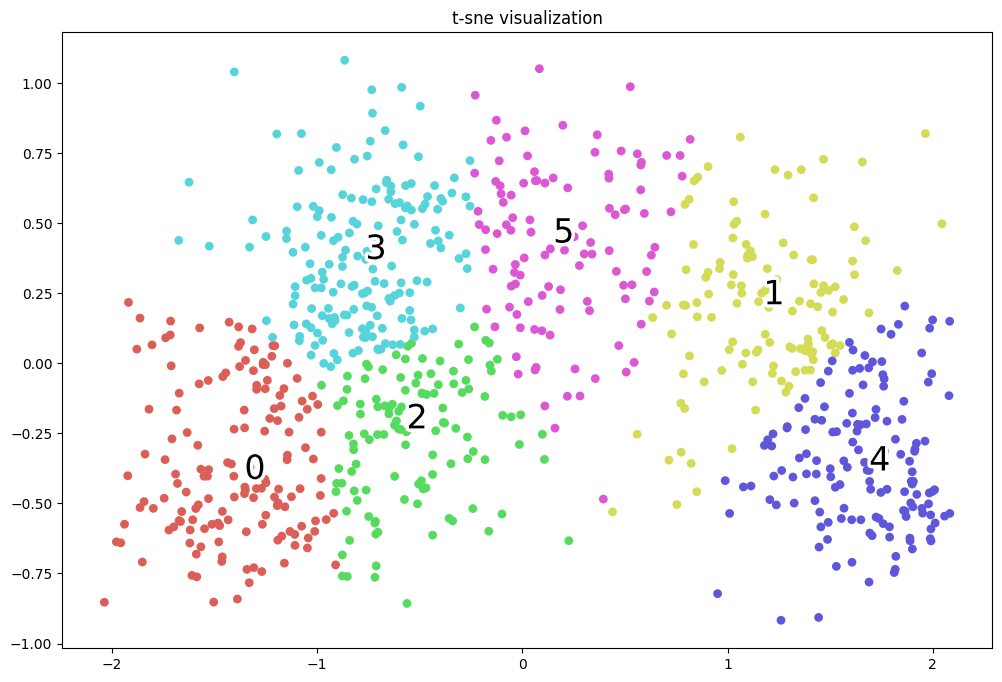

In [46]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int_)])

    # thêm nhãn cho mỗi cluster
    txts = []
    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([ PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')

labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)